In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Download stopwords
nltk.download('stopwords')

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ==== Configuration ====
MAX_WORDS = 10000
MAX_LEN = 100
BATCH_SIZE = 128
EPOCHS = 30

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/drive


In [2]:
# ==== Step 1: Load Full Dataset ====
columns = ['sentiment', 'id', 'date', 'query', 'user', 'text']
file_path = '/content/drive/MyDrive/Colab Notebooks/training1600000processednoemoticon.csv'
data = pd.read_csv(file_path, encoding='latin-1', header=None, names=columns)

# Filter only 0 and 4, map to 0 and 1
data = data[data['sentiment'].isin([0, 4])]
data['sentiment'] = data['sentiment'].map({0: 0, 4: 1})
data = data.reset_index(drop=True)

In [3]:
# ==== Step 2: Clean Text ====
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|@\S+|#\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words]
    return ' '.join(tokens)
data['cleaned_text'] = data['text'].astype(str).apply(clean_text)

In [4]:
# ==== Step 3: Tokenization & Padding ====
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(data['cleaned_text'])
sequences = tokenizer.texts_to_sequences(data['cleaned_text'])
X = pad_sequences(sequences, maxlen=MAX_LEN)
y = data['sentiment'].values

In [5]:
# ==== Step 4: Train-Test Split ====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# ==== Step 5: Build Model ====
model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=128),
    LSTM(128),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [7]:
# ==== Step 6: Training Callbacks ====
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

In [8]:
# ==== Step 7: Train Model ====
history = model.fit(
    X_train, y_train, validation_split=0.2, epochs=EPOCHS,
    batch_size=BATCH_SIZE, callbacks=[early_stop, lr_scheduler])

Epoch 1/30
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 94s 11ms/step - accuracy: 0.7615 - loss: 0.4879 - val_accuracy: 0.7894 - val_loss: 0.4461 - learning_rate: 0.0010
Epoch 2/30
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 143s 12ms/step - accuracy: 0.7958 - loss: 0.4350 - val_accuracy: 0.7928 - val_loss: 0.4404 - learning_rate: 0.0010
Epoch 3/30
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 141s 11ms/step - accuracy: 0.8063 - loss: 0.4160 - val_accuracy: 0.7956 - val_loss: 0.4377 - learning_rate: 0.0010
Epoch 4/30
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 142s 11ms/step - accuracy: 0.8145 - loss: 0.4014 - val_accuracy: 0.7954 - val_loss: 0.4398 - learning_rate: 0.0010
Epoch 5/30
7997/8000 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8231 - loss: 0.3856
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 141s 11ms/step - accuracy: 0.8231 - loss: 0.3856 - val_accuracy: 0.7947 - val_loss: 0.4477 - learning_rate: 0.0010
Epoch 6/30
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 140s 11ms/step - acc

In [9]:
# ==== Step 8: Evaluate Model ====
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy:.4f}")

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.7951 - loss: 0.4365

Test Accuracy: 0.7953


In [10]:
# ==== Step 9: Metrics & Plots ====
y_pred_probs = model.predict(X_test, verbose=0)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))
plt.figure(figsize=(6, 4))


Classification Report:

              precision    recall  f1-score   support

    Negative       0.80      0.79      0.79    159494
    Positive       0.79      0.80      0.80    160506

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

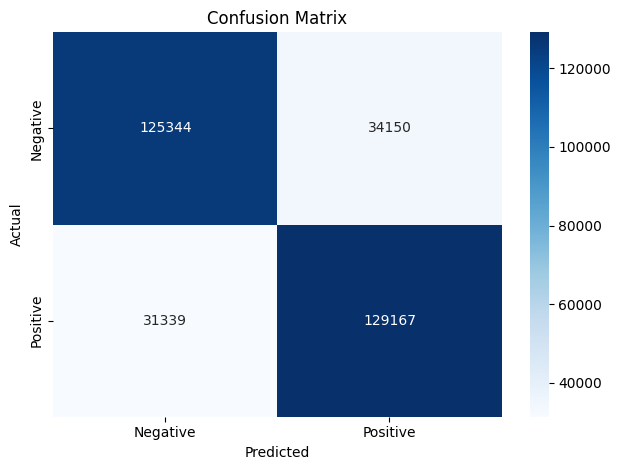

In [11]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

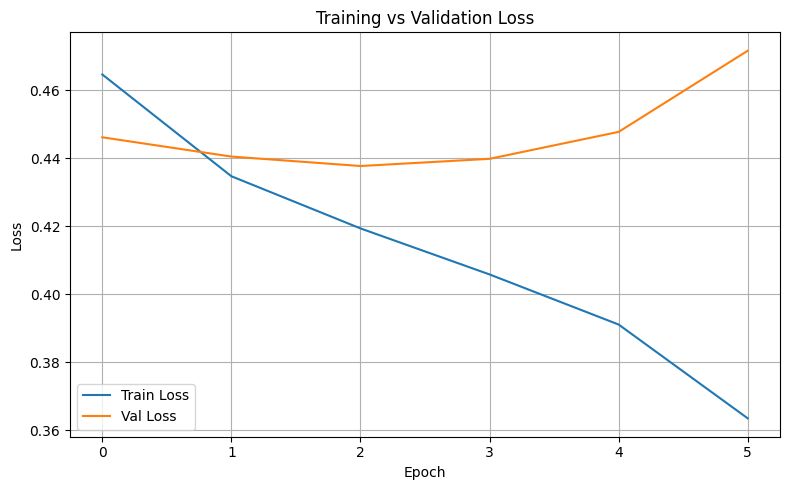

In [12]:
# Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

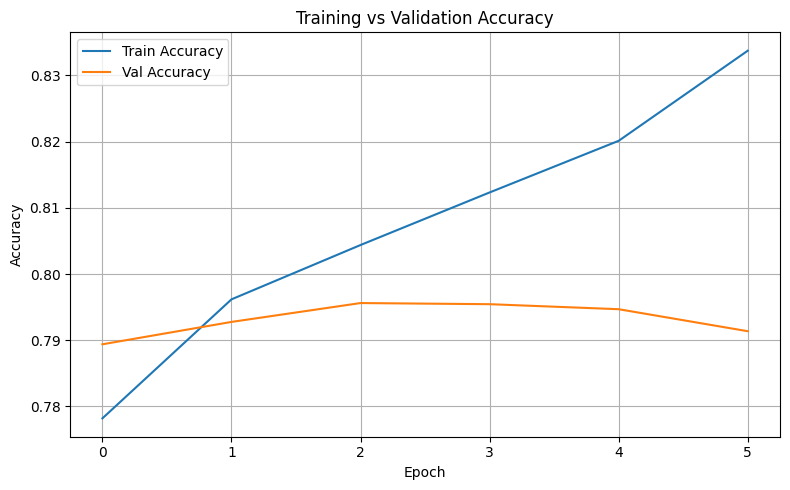

In [13]:
# Accuracy Curve
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# ==== Step 10: Custom Prediction ====
def predict_sentiment(text):
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=MAX_LEN)
    pred = model.predict(padded, verbose=0)
    return "Positive" if pred[0][0] > 0.5 else "Negative"

# ==== Examples ====
examples = [
    "I love this!",
    "This is terrible.",
    "Absolutely horrible experience",
    "What a great movie!",
    "I'm very disappointed.",
    "I hate this lovely day."
]
for t in examples:
    print(f"Tweet: '{t}' → Sentiment: {predict_sentiment(t)}")

Tweet: 'I love this!' → Sentiment: Positive
Tweet: 'This is terrible.' → Sentiment: Negative
Tweet: 'Absolutely horrible experience' → Sentiment: Negative
Tweet: 'What a great movie!' → Sentiment: Positive
Tweet: 'I'm very disappointed.' → Sentiment: Negative
Tweet: 'I hate this lovely day.' → Sentiment: Negative
